In [105]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [76]:
import pandas as pd
import numpy as np
import pyodbc as py

import random
from datetime import date, timedelta, datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.feature_selection import chi2, SelectKBest, SelectPercentile, mutual_info_classif, RFE, RFECV, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn import neighbors
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from time import time
from itertools import product

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import functions
import importlib
importlib.reload(functions)

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [3]:
tf.keras.backend.set_floatx('float64')

#### Load Data

In [4]:
importlib.reload(functions)

<module 'functions' from 'C:\\Users\\thoma\\Documents\\QM & BA\\QM & BA\\Seminar in QM & BA\\Seminar-QM-BA\\functions.py'>

In [5]:
#df = pd.read_csv('/Users/LV/Desktop/data_bol_complete.csv', low_memory = True)
df = pd.read_csv('/Users/thoma/Documents/seminar_data/cleaned_prepared_data.csv', low_memory = True)

In [6]:
df['orderDate']                   = pd.to_datetime(df['orderDate'])
df['cancellationDate']            = pd.to_datetime(df['cancellationDate'])
df['promisedDeliveryDate']        = pd.to_datetime(df['promisedDeliveryDate'])
df['shipmentDate']                = pd.to_datetime(df['shipmentDate'])
df['dateTimeFirstDeliveryMoment'] = pd.to_datetime(df['dateTimeFirstDeliveryMoment'])
df['startDateCase']               = pd.to_datetime(df['startDateCase'])
df['returnDateTime']              = pd.to_datetime(df['returnDateTime'])
df['registrationDateSeller']      = pd.to_datetime(df['registrationDateSeller'])

In [7]:
#Fixed Columns:
DATE = ['orderDate']
BASIC = ['totalPrice','quantityOrdered','fulfilmentByBol','countryCodeNL','countryOriginNL','countryOriginBE',
        'countryOriginDE','productTitleLength','promisedDeliveryDays','partnerSellingDays', 'orderCorona']
WEEK = ['orderMonday','orderTuesday','orderWednesday','orderThursday','orderFriday','orderSaturday','orderSunday']
MONTH = ['orderJanuary','orderFebruary','orderMarch','orderApril','orderMay','orderJune',
         'orderJuly','orderAugust','orderSeptember','orderOctober','orderNovember','orderDecember']
YEAR = ['orderYear2020']
GROUP = ['groupHealth','groupHome','groupSports','groupComputer','groupPets','groupToys','groupBooks', 
         'groupBaby', 'groupMusic', 'groupFood','groupOffice','groupFashion','groupOther','groupCar']

#Dynamic Columns:
TRANSPORTERX = ['transporterPOSTNL/X','transporterDHL/X','transporterDPD/X','transporterBRIEF/X','transporterOTHER/X']
KNOWNX = ['caseKnownX','returnKnownX','cancellationKnownX','onTimeDeliveryKnownX','lateDeliveryKnownX']
PRODUCTX = ['productOrderCountX','productTotalCountX','productTotalReturnedX','productReturnFractionX']
SELLERX = ['sellerDailyOrdersX']
HISTORICX = []
historic_variable = ['transporterCode','sellerId','productGroup']
for x in range(len(historic_variable)):
    HISTORICX = HISTORICX + [historic_variable[x]+'HistoricHappyX',historic_variable[x]+'HistoricUnhappyX',historic_variable[x]+'HistoricUnknownX']

#Determinants:
DETERMINANT = ['noReturn', 'noCase', 'noCancellation', 'onTimeDelivery']

#Classifications
CLASSIFICATION = ['generalMatchClassification','detailedMatchClassification','binaryMatchClassification','determinantClassification']

In [8]:
X_col = BASIC + WEEK + MONTH + YEAR + GROUP + TRANSPORTERX + KNOWNX + PRODUCTX + SELLERX + HISTORICX
Y_col = ['detailedMatchClassification']

#### Sample data

In [77]:
# df_ contains a sample of training + validation data
random.seed(100)
df_ = df.iloc[:int(0.75*len(df))].sample(n=1100000, replace=False, random_state=1).sort_values(by = 'orderDate').reset_index(drop = True).drop(columns=['Unnamed: 0'])

In [78]:
df.head()

,Unnamed: 0,orderDate,productId,sellerId,totalPrice,quantityOrdered,countryCode,cancellationDate,cancellationReasonCode,promisedDeliveryDate,shipmentDate,transporterCode,transporterName,transporterNameOther,dateTimeFirstDeliveryMoment,fulfilmentType,startDateCase,cntDistinctCaseIds,returnDateTime,quantityReturned,returnCode,productTitle,brickName,chunkName,productGroup,productSubGroup,productSubSubGroup,registrationDateSeller,countryOriginSeller,currentCountryAvailabilitySeller,calculationDefinitive,noCancellation,onTimeDelivery,noCase,hasOneCase,hasMoreCases,noReturn,detailedMatchClassification,generalMatchClassification,caseDays,returnDays,cancellationDays,actualDeliveryDays,shipmentDays,partnerSellingDays,promisedDeliveryDays,orderYear,orderMonth,orderWeekday,orderCorona,orderMonday,orderTuesday,orderWednesday,orderThursday,orderFriday,orderSaturday,orderSunday,orderJanuary,orderFebruary,orderMarch,orderApril,orderMay,orderJune,orderJuly,orderAugust,orderSeptember,orderOctober,orderNovember,orderDecember,orderYear2020,productTitleLength,fulfilmentByBol,countryCodeNL,countryOriginNL,countryOriginBE,countryOriginDE,determinantClassification,binaryMatchClassification,transporterCodeGeneral,productGroupGeneral,groupHealth,groupHome,groupSports,groupComputer,groupPets,groupToys,groupBooks,groupBaby,groupMusic,groupFood,groupOffice,groupFashion,groupOther,groupCar
0,0,2019-01-01,9200000103390344,1244284,1.599388,1,NL,NaT,NaN,2019-01-04,2019-01-02,TNT_BRIEF,PostNL Briefpost,NaN,NaT,FBR,NaT,NaN,NaT,NaN,NaN,Velvet Scrunchie Pale Pink,Haar – Accessoires,Haaraccessoire,Daily Care PG,Haar,Haar Accessoires,2016-12-19,NL,NL,True,True,NaN,True,0.0,0.0,True,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,1.0,743,3,2019,1,1,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,26,False,True,True,False,False,Unknown delivery,UNKNOWN,BRIEF,Health & Care,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,2019-01-01,9200000065456100,1167286,5.062595,1,NL,NaT,NaN,2019-01-07,2019-01-02,DPD-NL,DPD Nederland,NaN,NaT,FBR,2019-01-03,2.0,NaT,NaN,NaN,Inventum MN306C - Combi-magnetron,Magnetrons,Vrijstaande magnetron,Major Domestic Appliances PG,Cooking,Cooking,2016-04-15,NL,NL,True,True,NaN,False,0.0,1.0,True,HEAVILY UNHAPPY,UNHAPPY,2.0,NaN,NaN,NaN,1.0,991,6,2019,1,1,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,33,False,True,True,False,False,Case + Unknown delivery,KNOWN,DPD,"Home, Cooking & Household",False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2019-01-01,9200000024539481,888610,3.401197,1,BE,NaT,NaN,2019-01-03,2019-01-02,BPOST_BE,Bpost Belgie,NaN,2019-01-03 08:17:00,FBB,NaT,NaN,NaT,NaN,NaN,Perfect Push Up V2,Fitness Accessoires,Opdruksteun,Sporting Equipment,Fitness Klein,Fitnessmaterialen,2013-12-21,NL,NL,True,True,True,True,0.0,0.0,True,HAPPY,HAPPY,NaN,NaN,NaN,2.0,1.0,1837,2,2019,1,1,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,18,True,False,True,False,False,All good,KNOWN,OTHER,"Sports, Outdoor & Travel",False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,3,2019-01-01,9200000056338594,1308208,3.471966,2,NL,2019-01-02,SELLER_UNDELIV,2019-01-03,NaT,NaN,NaN,NaN,NaT,FBB,NaT,NaN,NaT,NaN,NaN,RGB led strip - 5m - Set RGB - kleuren - Inclu...,Verlichting – Vast,Led-strip,Lighting,Slimme Verlichting,Slimme Led-Strips,2017-09-15,NL,NL,True,False,NaN,True,0.0,0.0,True,HEAVILY UNHAPPY,UNHAPPY,NaN,NaN,1.0,NaN,NaN,473,2,2019,1,1,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,93,True,True,True,False,False,Cancellation,KNOWN,OTHER,"Home, Cooking & Household",False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,4,2019-01-01,920000008515294

### Hierarchical Classification Models

In [8]:
# classifier = LogisticRegression(random_state=0, class_weight='balanced')
# classifier = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators = 10)
# classifier = svm.LinearSVC(C=1, penalty="l1", dual=False, class_weight = 'balanced')
# classifier = HistGradientBoostingClassifier(random_state=0)
# classifier = DecisionTreeClassifier(random_state=0, max_depth=10, class_weight='balanced')
# classifier = KerasClassifier(build_fn = functions.neuralNetwork,epochs = 10,verbose = 0)

In [162]:
ch = ClassHierarchy('ORDERS')
ch.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
ch.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
ch.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')

HCtest = HierarchicalClassifier(ch)
# HC.fit_classifiers({'ORDERS'  : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
#                     'KNOWN'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
#                     'UNHAPPY' : KerasClassifier(build_fn = functions.neuralNetwork,epochs = 10,verbose = 0)})
HCtest.fit_classifiers({'ORDERS'  : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 9),
                    'KNOWN'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 6),
                    #'UNHAPPY' : KerasClassifier(build_fn = functions.neuralNetwork,output=3,nodes=20,layers=1,droprate=0,epochs = 10,verbose = 0)})
                        'UNHAPPY' : RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators = 23)})

In [14]:
ch = ClassHierarchy('ORDERS')
ch.add_node(['OTHER','UNHAPPY'], 'ORDERS')
ch.add_node(['HAPPY','UNKNOWN'], 'OTHER')
ch.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')

HC = HierarchicalClassifier(ch)
HC.fit_classifiers({'ORDERS'  : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
                    'OTHER'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
                    'UNHAPPY' : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10)})

#### Single fit single point in time

In [74]:
X_preBurn, y_preBurn = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, 0)
index = range(0, X_preBurn.shape[0])

X_train_val = X_preBurn.iloc[int(0.1*len(X_preBurn)):]
y_train_val = y_preBurn.iloc[int(0.1*len(y_preBurn)):]

#X_train_val = X.iloc[0:int(0.75*len(X))]
X_train = X_train_val.iloc[0:int(0.8*len(X_train_val))]
X_val = X_train_val.iloc[int(0.8*len(X_train_val)):]
       
#y_train_val = y.iloc[0:int(0.75*len(y))]
y_train = y_train_val.iloc[0:int(0.8*len(y_train_val))]
y_val = y_train_val.iloc[int(0.8*len(y_train_val)):]

#X_test_full = X.iloc[int(0.75*len(X)):]
#y_test_full = y.iloc[int(0.75*len(y)):]

In [134]:
HCtest = HCtest.fit(X_train_val,y_train_val)
pred = HCtest.predict(X_test)

In [51]:
f1_score_ancestors(ch, y_test['detailedMatchClassification'], pred, beta = 1)

0.8486035695465898

In [92]:
day_block_scores(HC, y_test['detailedMatchClassification'], pred, print_output = True)

Percentage labelled	: 100.0 %
Percentage leaf node	: 100.0 %
Accuracy leaf node	: 82.8 %


TypeError: type numpy.ndarray doesn't define __round__ method

In [ ]:
# class_report(y_test['detailedMatchClassification'], pred)
# global_scores(y_test['detailedMatchClassification'], pred)
# local_scores(y_test['detailedMatchClassification'], pred)
# precision_score_ancestors(ch, y_test['detailedMatchClassification'], pred)
# recall_score_ancestors(ch, y_test['detailedMatchClassification'], pred)
# f1_score_ancestors(ch, y_test['detailedMatchClassification'], pred)

#### Hyper-parameter tuning

In [26]:
def neuralNetwork(output, nodes, layers, droprate):
    
    model = Sequential()

    model.add(Dense(units = nodes, activation = 'relu'))

    for i in range(1,layers+1):
        model.add(Dense(units = nodes, activation = 'relu'))
        model.add(Dropout(droprate))

    model.add(Dense(units = output, activation = 'softmax')) #units should equal number of labels

    if output == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'categorical_crossentropy'
        
    model.compile(optimizer = 'adam', 
                  loss = loss, 
                  metrics = ['accuracy'])

    return model

In [33]:
combinations = [i for i in product(['DT','RF','NN'],repeat=3)]

In [34]:
def get_hyperspace(combination):
    
    param_hyperopt = {}
    
    for node, clf in enumerate(combination):
        
        if clf == 'DT':
            hyper = {'DT_criterion_'+str(node)   : hp.choice('DT_criterion_'+str(node) ,['gini','entropy']),
                     'DT_max_depth_'+str(node)   : scope.int(hp.quniform('DT_max_depth_'+str(node), 5, 15, 1))}
        elif clf == 'RF':
            hyper = {'RF_max_depth_'   +str(node) : scope.int(hp.quniform('RF_max_depth_'+str(node), 5, 15, 1)),
                     'RF_n_estimators_'+str(node) : scope.int(hp.quniform('RF_n_estimators_'+str(node), 10, 50, 5))}
        elif clf == 'NN':
            hyper = {'NN_dropout_'+str(node)  : hp.uniform('NN_dropout_'+str(node), 0, 0.5),
                     'NN_nodes_'  +str(node)  : scope.int(hp.quniform('NN_nodes_'+str(node), 5, 50, 5)),
                     'NN_layers_' +str(node)  : scope.int(hp.quniform('NN_layers_'+str(node), 1, 2, 1))}
            
        param_hyperopt = {**param_hyperopt, **hyper}
        
    return param_hyperopt

In [35]:
combination = ('DT', 'DT', 'DT')

def clf_hypers(params):

    clf = {}
    
    for ix, node in enumerate(['ORDERS','KNOWN','UNHAPPY']):

        node_hypers = [x for x in list(params.keys()) if x[-1] == str(ix)]

        if combination[ix] == 'DT':
            clf[node] = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = params[node_hypers[1]], criterion = params[node_hypers[0]])
        elif combination[ix] == 'RF':
            clf[node] = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = params[node_hypers[0]], n_estimators = params[node_hypers[1]])
        elif combination[ix] == 'NN':
            if ix == 2:
                output = 3
            else:
                output = 2
            clf[node] = KerasClassifier(neuralNetwork, output = output, nodes = params[node_hypers[1]], layers = params[node_hypers[2]], droprate = params[node_hypers[0]], epochs = 15, verbose = 0)

    return clf

In [36]:
Tree = ClassHierarchy('ORDERS')
Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')

In [37]:
def objective_function(params):
    
    HC = HierarchicalClassifier(Tree)
    HC.fit_classifiers(clf_hypers(params))
    
    HC = HC.fit(X_train,y_train)
    pred = HC.predict(X_val)
    
    score = f1_score_ancestors(Tree, y_val['detailedMatchClassification'], pred, beta=1)
    #cross validation score to be implemented
    
    return {'loss': -score, 'status': STATUS_OK}

In [38]:
def hyperopt(param_space, X_train, y_train, X_val, y_val, num_eval):

    trials = Trials()

    best_param = fmin(objective_function, 
                      param_space, 
                      algo = tpe.suggest, 
                      max_evals = num_eval, 
                      trials = trials,
                      rstate = np.random.RandomState(1))
    
    loss = [x['result']['loss'] for x in trials.trials]
        
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Parameter combinations evaluated: ", num_eval)
    
    return best_param, trials

In [39]:
best_param, trials = hyperopt(get_hyperspace(('DT', 'DT', 'DT')), X_train, y_train, X_val, y_val, 10)

100%|███████████████████████████████████████████████| 10/10 [06:01<00:00, 36.12s/trial, best loss: -0.8504416931383224]

##### Results
Score best parameters:  0.8504416931383224
Best parameters:  {'DT_criterion_0': 1, 'DT_criterion_1': 0, 'DT_criterion_2': 1, 'DT_max_depth_0': 11.0, 'DT_max_depth_1': 6.0, 'DT_max_depth_2': 11.0}
Parameter combinations evaluated:  10


In [169]:
results, best_param = hyperopt(param_hyperopt, X_train, y_train, X_val, y_val, 10)

 10%|████▌                                        | 1/10 [11:16<1:41:26, 676.27s/trial, best loss: -0.8012717947937803]


KeyboardInterrupt: 

In [140]:
best_param

{'DT_criterion': 1,
 'DT_max_depth': 5.0,
 'NN_dropout': 0.3180872672719526,
 'NN_layers': 2.0,
 'NN_nodes': 40.0,
 'RF_max_depth': 12.0,
 'RF_n_estimators': 25.0}

In [159]:
def test_fold_score(X, y, X_test, y_test, n_test_folds, total_test_size):
    
    n_test_folds = 5
    criteriaList = ['gini','entropy']

    HC = HierarchicalClassifier(Tree)
    HC.fit_classifiers({'ORDERS'  : RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators = int(best_param['RF_n_estimators']), max_depth = int(best_param['RF_max_depth'])),
                        'KNOWN'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = int(best_param['DT_max_depth']), criterion = criteriaList[best_param['DT_criterion']]),
                        'UNHAPPY' : KerasClassifier(functions.neuralNetwork, output = 3, nodes = int(best_param['NN_nodes']), layers = int(best_param['NN_layers']), droprate = best_param['NN_dropout'], epochs = 15, verbose = 0)})

    score_fold = np.zeros(n_test_folds)

    for i in range(n_test_folds):
        X_test = X_test_full.iloc[int((1/n_test_folds)*i*len(X_test_full)):int((1/n_test_folds)*i*len(X_test_full)+(1/n_test_folds)*len(X_test_full))]
        y_test = y_test_full.iloc[int((1/n_test_folds)*i*len(y_test_full)):int((1/n_test_folds)*i*len(y_test_full)+(1/n_test_folds)*len(y_test_full))]
    
        X_train_val = X.iloc[int((total_test_size/n_test_folds)*i*len(X)):int((total_test_size/n_test_folds)*i*len(X)+(1-total_test_size)*len(X))]
        y_train_val = y.iloc[int((total_test_size/n_test_folds)*i*len(y)):int((total_test_size/n_test_folds)*i*len(y)+(1-total_test_size)*len(y))]
    
        HC = HC.fit(X_train_val,y_train_val)
        pred = HC.predict(X_test)
    
        score_fold[i] = f1_score_ancestors(Tree, y_test['detailedMatchClassification'], pred, beta=1)
    
        print(i)
    
    score = score_fold.mean()
    return score

In [160]:
test_fold_score(X, y, X_test, y_test, n_test_folds = 5, total_test_size = 0.25)

0
1
2
3
4


0.8034710883106735

In [ ]:
def objective_function(params):
    
    Tree = ClassHierarchy('ORDERS')
    Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
    Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
    Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')
    
    HC = HierarchicalClassifier(Tree)
    HC.fit_classifiers({'ORDERS'  : RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators = params['RF_n_estimators'], max_depth = params['RF_max_depth']),
                        'KNOWN'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = params['DT_max_depth'], criterion = params['DT_criterion']),
                        'UNHAPPY' : KerasClassifier(neuralNetwork, nodes = params['NN_nodes'], layers = params['NN_layers'], epochs = 10, verbose = 0)})
    
    score_fold = np.zeros(3)
    
    for i in range(n_folds):
        X_train_val = X.iloc[int(0.1*i):int(0.1*i+0.5*len(X))]
        X_train = X_train_val.iloc[0:int(0.8*len(X_train_val))]
        X_val = X_train_val.iloc[int(0.8*len(X_train_val)):]
        
        y_train_val = y.iloc[int(0.1*i):int(0.1*i+0.5*len(y))]
        y_train = y_train_val.iloc[0:int(0.8*len(y_train_val))]
        y_val = y_train_val.iloc[int(0.8*len(y_train_val)):]
    
        HC = HC.fit(X_train,y_train)
        pred = HC.predict(X_val)
    
        score_fold[i] = f1_score_ancestors(Tree, y_val['detailedMatchClassification'], pred, beta=1)
    #print(metrics.accuracy_score(y_test, pred))
    #cross validation score to be implemented
    
    score = score_fold.mean()
    
    return {'loss': -score, 'status': STATUS_OK}

#### System: Non-mandaroty dynamic prediction X days after order date

In [ ]:
def dynamicHierarchicalClassifier(START, END, threshold):  

    predictions = pd.DataFrame()
    statistics = {'%classified':{},
                  '%accuracy'  :{},
                  '%precision' :{},
                  '%recall'    :{},
                  '%blocking'  :{}}
    
    dynamic_threshold = np.linspace(0.95,threshold,(END-START))
    static_threshold = np.full((END-START),threshold)
    threshold_count = 0

    for DAYS in range(START, END+1):

        X, y = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, DAYS)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, shuffle=False)

        Tree = ClassHierarchy('ORDERS')
        Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
        Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
        Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')

        HC = HierarchicalClassifier(Tree)
        HC.fit_classifiers({'ORDERS'  : RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators = 10),
                            'KNOWN'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
                            'UNHAPPY' : KerasClassifier(build_fn = functions.neuralNetwork, epochs = 10, verbose = 0)})
        
        HC = HC.fit(X_train,y_train)

        if DAYS == START: #create dataframe to save predictions
            y_hat = pd.DataFrame([Tree.root] * len(X_test),
                                    columns=[DAYS],
                                    index=X_test.index)
            index_no_leaf = X_test.index
        else:
            y_hat[DAYS] = y_hat[DAYS - 1]

        if DAYS < END:
            pred = HC.predict_proba(X_test.loc[index_no_leaf], threshold = dynamic_threshold[threshold_count])

            check_no_leaf = ~pred.isin(Tree._get_leaf_nodes())
            index_no_leaf = check_no_leaf[check_no_leaf].index
            check_leaf = pred.isin(Tree._get_leaf_nodes())
            index_leaf = check_leaf[check_leaf].index

            y_hat_stage = pd.DataFrame(pred, index = index_leaf)
        else:
            pred = HC.predict(X_test.loc[index_no_leaf]) #last day you want a label for each order
            y_hat_stage = pd.DataFrame(pred, index = index_no_leaf)
            index_leaf = X_test.index
            
        y_hat = y_hat.assign(stage_col = y_hat_stage)
        y_hat.stage_col = y_hat.stage_col.fillna(y_hat[DAYS]) #fill previously predicted labels
        y_hat = y_hat.drop(DAYS, axis=1)
        y_hat = y_hat.rename(columns={'stage_col': DAYS})
        
        current_pred = y_hat.iloc[:, y_hat.shape[1] - 1]

        fraction_label, fraction_leaf, accuracy_leaf, precision_leaf, recall_leaf, fraction_blocked = day_block_scores(HC, y_test, current_pred)
        statistics['%classified'][DAYS] = fraction_leaf
        statistics['%accuracy'][DAYS] = accuracy_leaf
        statistics['%precision'][DAYS] = precision_leaf
        statistics['%recall'][DAYS] = recall_leaf
        statistics['%blocking'][DAYS] = fraction_blocked

        threshold_count += 1
        print('DAYS: ',DAYS)
     
    final_pred = y_hat.iloc[:, y_hat.shape[1] - 1]
    
    statistics['precision_H'] = precision_score_ancestors(Tree, y_test['detailedMatchClassification'], final_pred)
    statistics['recall_H'] = recall_score_ancestors(Tree, y_test['detailedMatchClassification'], final_pred)
    statistics['f1_H'] = f1_score_ancestors(Tree, y_test['detailedMatchClassification'], final_pred)
        
    return final_pred, statistics

In [61]:
pred, statistics = dynamicHierarchicalClassifier(0,10,0.8)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4
DAYS:  5
DAYS:  6
DAYS:  7
DAYS:  8
DAYS:  9
DAYS:  10


In [42]:
days, precision_list = zip(*statistics['%precision'].items()) 
P_Happy, P_Heavy, P_Medium, P_Mild, P_Unk = zip(*precision_list) 

In [35]:
days, recall_list = zip(*statistics['%recall'].items()) 
R_Happy, R_Heavy, R_Medium, R_Mild, R_Unk = zip(*recall_list) 

In [57]:
np.unique(y_test)

array(['HAPPY', 'HEAVILY UNHAPPY', 'MEDIUM UNHAPPY', 'MILDLY UNHAPPY',
       'UNKNOWN'], dtype=object)

In [58]:
local_scores(y_test, pred)

(array([0.93595777, 0.72900158, 0.68055556, 0.96074337, 0.93501152]),
 array([0.99902783, 0.45231072, 0.36392573, 0.51459568, 0.98295054]),
 array([0.96646493, 0.55825243, 0.47424819, 0.67021122, 0.95838192]))

In [59]:
pred_general = pred.replace({'MILDLY UNHAPPY':'UNHAPPY',
                             'MEDIUM UNHAPPY':'UNHAPPY',
                             'HEAVILY UNHAPPY':'UNHAPPY'})
test_general = y_test.replace({'MILDLY UNHAPPY':'UNHAPPY',
                             'MEDIUM UNHAPPY':'UNHAPPY',
                             'HEAVILY UNHAPPY':'UNHAPPY'})
local_scores(test_general, pred_general)

(array([0.93595777, 0.9654636 , 0.93501152]),
 array([0.99902783, 0.52402263, 0.98295054]),
 array([0.96646493, 0.6793279 , 0.95838192]))

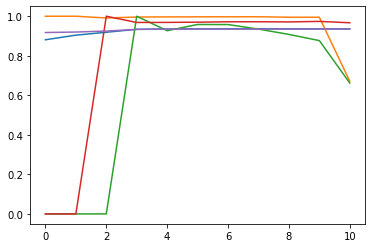

In [634]:
# plt.plot(days, P_Happy)
# plt.plot(days, P_Heavy)
# plt.plot(days, P_Medium)
# plt.plot(days, P_Mild)
# plt.plot(days, P_Unk)

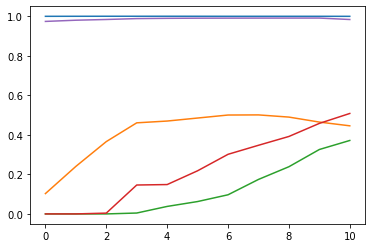

In [635]:
# plt.plot(days, R_Happy)
# plt.plot(days, R_Heavy)
# plt.plot(days, R_Medium)
# plt.plot(days, R_Mild)
# plt.plot(days, R_Unk)

#### Non-mandatory predictions 0,1,2,... days after order date

In [508]:
PREDICT_DAYS = 10
threshold = 0.8

predictions = pd.DataFrame()
results = {}

dynamic_threshold = np.linspace(0.95,threshold,PREDICT_DAYS+1)
dynamic_count = 0

for DAYS in range(PREDICT_DAYS+1):
    
    X, y = functions.dataX(df_, DATE, X_col, Y_col, historic_variable, DAYS)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

    Tree = ClassHierarchy('ORDERS')
    Tree.add_node(['UNKNOWN','KNOWN'], 'ORDERS')
    Tree.add_node(['HAPPY','UNHAPPY'], 'KNOWN')
    Tree.add_node(['MILDLY UNHAPPY','MEDIUM UNHAPPY','HEAVILY UNHAPPY'], 'UNHAPPY')

    HC = HierarchicalClassifier(Tree)
    HC.fit_classifiers({'ORDERS'  : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
                        'KNOWN'   : DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth = 10),
                        'UNHAPPY' : KerasClassifier(build_fn = functions.neuralNetwork, epochs = 15, verbose = 0)})
    
    HC = HC.fit(X_train,y_train['detailedMatchClassification'])
    pred = HC.predict_proba(X_test, threshold = dynamic_threshold[dynamic_count])
    
    fraction_label, fraction_leaf, accuracy_leaf = day_block_scores(HC, y_test['detailedMatchClassification'], pred)
    
    predictions[DAYS] = pred
    results['DAY '+str(DAYS)] = (fraction_label, fraction_leaf, accuracy_leaf)
    
    dynamic_count += 1
    
    print('DAYS: ',DAYS)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3


In [509]:
changes = {}
for i in range(0,predictions.shape[1]-1):
    col_t0 = predictions.iloc[:,i]
    col_t1 = predictions.iloc[:,i+1]
    
    check_leaf_t0 = col_t0.isin(Tree._get_leaf_nodes())
    index_leaf_t0 = check_leaf_t0[check_leaf_t0].index
    
    col_t0_leaf = col_t0.loc[index_leaf_t0]
    col_t1_leaf = col_t1.loc[index_leaf_t0]
    
    check_similarity = (col_t0_leaf == col_t1_leaf)
    if i == 0:
        ix = check_similarity[check_similarity == False].index
    
    changes['DAY '+str(i+1)] = 1 - (check_similarity.sum() / col_t0_leaf.count())

In [510]:
days0, stats = zip(*results.items())
fraction_label, fraction_leaf, accuracy_leaf = zip(*stats)
days1, change = zip(*changes.items())

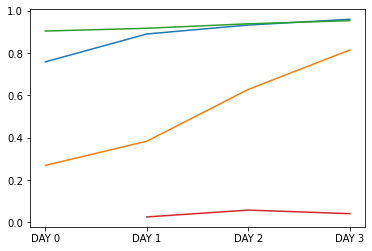

In [636]:
plt.plot(days0,fraction_label)
plt.plot(days0,fraction_leaf)
plt.plot(days0,accuracy_leaf)
plt.plot(days1,change)

#### Functions

In [11]:
def global_scores(y_true, y_pred, average = 'macro'):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    scores = metrics.precision_recall_fscore_support(y_true, y_pred, average = average)
    return accuracy, scores[0], scores[1], scores[2]

def local_scores(y_true, y_pred):
    labels = np.unique(y_true)
    scores = metrics.precision_recall_fscore_support(y_true, y_pred, average = None, labels = labels, beta = 1)
    return scores[0], scores[1], scores[2]

def class_report(y_true, y_pred):
    print(metrics.classification_report(y_true, y_pred))

def _aggregate_class_sets(set_function, y_true, y_pred):
    intersection_sum = 0
    true_sum = 0
    predicted_sum = 0
    for true, pred in zip(list(y_true), list(y_pred)):
        true_set = set([true] + set_function(true))
        pred_set = set([pred] + set_function(pred))
        intersection_sum += len(true_set.intersection(pred_set))
        true_sum += len(true_set)
        predicted_sum += len(pred_set)
    return (true_sum, predicted_sum, intersection_sum)

def _fbeta_score_class_sets(set_function, y_true, y_pred, beta=1):
    true_sum, predicted_sum, intersection_sum = _aggregate_class_sets(set_function, y_true, y_pred)
    precision = intersection_sum / predicted_sum
    recall = intersection_sum / true_sum
    return ((beta ** 2 + 1) * precision * recall) / ((beta ** 2 * precision) + recall)

def precision_score_ancestors(class_hierarchy, y_true, y_pred):
    true_sum, predicted_sum, intersection_sum = _aggregate_class_sets(
        class_hierarchy._get_ancestors, y_true, y_pred)
    return intersection_sum / predicted_sum

def recall_score_ancestors(class_hierarchy, y_true, y_pred):
    true_sum, predicted_sum, intersection_sum = _aggregate_class_sets(
        class_hierarchy._get_ancestors, y_true, y_pred)
    return intersection_sum / true_sum

def f1_score_ancestors(class_hierarchy, y_true, y_pred, beta):
    return _fbeta_score_class_sets(class_hierarchy._get_ancestors, y_true, y_pred, beta=beta)

def day_block_scores(classifier, y_true, y_pred, print_output = False):
    
    check_label = (y_pred != classifier.class_hierarchy.root)
    index_label = check_label[check_label].index
    
    fraction_label = check_label.sum()/y_pred.count()
    fraction_leaf = y_pred.isin(classifier.class_hierarchy._get_leaf_nodes()).sum()/y_pred.count()
    
    check_leaf = y_pred.isin(classifier.class_hierarchy._get_leaf_nodes())
    index_leaf = check_leaf[check_leaf].index
    
    accuracy_leaf, precision_leaf_macro, recall_leaf_macro, f1_leaf_macro = global_scores(y_true.loc[index_leaf],y_pred.loc[index_leaf])
    precision_leaf, recall_leaf, f1_leaf = local_scores(y_true,y_pred)
    
#     fraction_type = {}
#     for match_type in np.unique(y_true):
#         test_type_check = (y_true == match_type)
#         test_type_index = test_type_check[test_type_check].index
#         pred_type_check = y_pred.loc[test_type_index]
#         pred_type_index = pred_type_check[pred_type_check == match_type].index
#         fraction_type[match_type] = len(pred_type_index) / len(test_type_check)
    
    if len(index_leaf) != len(y_true):
        fraction_blocked = classifier.blocking
    else:
        fraction_blocked = None
    
    if print_output == True:
        print('Percentage labelled\t:'  ,round(fraction_label*100,2),'%')
        print('Percentage leaf node\t:' ,round(fraction_leaf*100,2) ,'%')
        print('Accuracy leaf node\t:'   ,round(accuracy_leaf*100,2) ,'%')
        print('Precision leaf node\t:'  ,round(precision_leaf*100,2),'%')
        print('Recall leaf node\t:'     ,round(recall_leaf*100,2)   ,'%')

        for node, fraction in fraction_blocked.items():
            print('Percentage blocked at '+node+'\t:',round(fraction*100,2),'%')
    else:    
        return fraction_label, fraction_leaf, accuracy_leaf, precision_leaf, recall_leaf, fraction_blocked

In [12]:
class ClassHierarchy:
    
    def __init__(self, root):
        self.root = root
        self.nodes = {}
        
    def add_node(self, children, parent):
        for child in children:
            self.nodes[child] = parent
            
    def _get_leaf_nodes(self):
        leaf_nodes = []
        for child in self.nodes.keys():
            if self._get_children(child) == []:
                leaf_nodes.append(child)
        return leaf_nodes

    def _get_children(self, parent):
        return sorted([child for child, childs_parent in
                       self.nodes.items() if childs_parent == parent])
    
    def _get_parent(self, child):
        return self.nodes[child] if (child in self.nodes and child != self.root) else self.root
    
    def _get_ancestors(self, child):
        # Not including root, not including the child
        ancestors = []
        while True:
            child = self._get_parent(child)
            if child == self.root:
                break
            ancestors.append(child)
        return ancestors

In [13]:
class HierarchicalClassifier:

    def __init__(self, class_hierarchy):
        self.stages = {}
        self.class_hierarchy = class_hierarchy
        self._create_stages(self.stages, self.class_hierarchy.root, 0)

    def _create_stages(self, stages, parent, depth):
        # Get the children of this parent
        children = self.class_hierarchy._get_children(parent)
        
        if len(children) > 0:
            stage = {}
            stage['depth'] = depth
            stage['labels'] = children
            stage['classes'] = stage['labels'] + [parent]
            stage['target'] = 'target_stage_' + parent
            stages[parent] = stage

            for node in children:
                self._create_stages(stages, node, depth + 1)
                
    def _recode_label(self, classes, label):

        while label != self.class_hierarchy.root and label not in classes:
            label = self.class_hierarchy._get_parent(label)
        return label
                
    def _prep_data(self, X, y):
        
        Xcols = range(0, X.shape[1])
        Ycol = X.shape[1]
        
        df = pd.concat([X, y], axis=1, ignore_index=True)
        # Create a target column for each stage with the recoded labels
        for stage_name, stage_info in self.stages.items():
            df[stage_info['target']] = pd.DataFrame.apply(df[[Ycol]],
                                    lambda row: self._recode_label(stage_info['classes'], row[Ycol]),
                                    axis=1)
        return df, Xcols
    
    def _label_mapping(self, y_train, stage_name):
        labels = np.unique(y_train)
        int_label_mapping = dict(enumerate(labels))
        label_int_mapping = {y:x for x,y in int_label_mapping.items()}
        self.stages[stage_name]['mapping'] = {'int_label':int_label_mapping,
                                              'label_int':label_int_mapping}
        #return int_label_mapping, label_int_mapping
        
    def _class_weights(self, y_train, stage_name):
        class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
        class_weights = dict(enumerate(class_weights))
        self.stages[stage_name]['classifier'].set_params(class_weight = class_weights)
    
    def fit_classifiers(self, classifiers):
        """
        Fit a classifier to each stage
        """
        if classifiers.keys() != self.stages.keys():
             raise ValueError('Your assigned classifiers do not match the stages of the hierarchy, fit a classifier to each of: '+self.stages.keys())
        else:
            for stage, classifier in classifiers.items():
                self.stages[stage]['classifier'] = classifier
    
    def fit(self, X, y):
        """
        Build a multi-classifier from training data (X, y).
        """
        df, Xcols = self._prep_data(X, y)
        self.scaler = preprocessing.MinMaxScaler().fit(X)
        
        for stage_name, stage_info in self.stages.items():
            
            dfFilter = df[df[stage_info['target']].isin(stage_info['classes'])]
            
            X_train = dfFilter[Xcols]
            y_train = dfFilter[[stage_info['target']]]
                        
            #warning - no samples to fit for stage
            if isinstance(stage_info['classifier'], KerasClassifier):
                y_train_col = pd.Series(np.ravel(y_train))
                self._class_weights(y_train_col, stage_name)
                self._label_mapping(y_train_col, stage_name)
                y_encoded = y_train_col.map(stage_info['mapping']['label_int'])
                y_dummy = pd.DataFrame(np_utils.to_categorical(y_encoded))
                X_scaled = pd.DataFrame(self.scaler.transform(X_train))
                stage_info['classifier'].fit(X_scaled, y_dummy)
            else:
                stage_info['classifier'] = stage_info['classifier'].fit(X_train, y_train)
            #print('Stage '+stage_name+' succesfully fitted')

        return self
    
    def predict(self, X):
        
        stage_number = 0
        for stage_name, stage_info in self.stages.items():
            
            if stage_name == self.class_hierarchy.root:
                y_hat = pd.DataFrame([self.class_hierarchy.root] * len(X),
                                        columns=[self.class_hierarchy.root],
                                        index=X.index)
            else:
                y_hat[stage_name] = y_hat[list(self.stages.keys())[stage_number - 1]]
            stage_number += 1             
                
            X_test = X[y_hat[stage_name].isin([stage_name])]  #warning - no samples to fit for stage
            
            if isinstance(stage_info['classifier'], KerasClassifier):
                X_scaled = pd.DataFrame(self.scaler.transform(X_test))
                y_pred = pd.Series(stage_info['classifier'].predict(X_scaled)).map(stage_info['mapping']['int_label'])
                y_hat_stage = pd.DataFrame(y_pred.values, index = X_test.index)
            else:
                y_hat_stage = pd.DataFrame(stage_info['classifier'].predict(X_test), index = X_test.index)
                
            y_hat = y_hat.assign(stage_col = y_hat_stage)
            y_hat.stage_col = y_hat.stage_col.fillna(y_hat[stage_name]) #fill previously predicted labels
            y_hat = y_hat.drop(stage_name, axis=1)
            y_hat = y_hat.rename(columns={'stage_col': stage_name})
            
        return y_hat.iloc[:, y_hat.shape[1] - 1]     
    
    def predict_proba(self, X, threshold = 0.5):
        
        self.blocking = {}
        stage_number = 0
        for stage_name, stage_info in self.stages.items():
            
            if stage_name == self.class_hierarchy.root:
                y_hat = pd.DataFrame([self.class_hierarchy.root] * len(X),
                                        columns=[self.class_hierarchy.root],
                                        index=X.index)
            else:
                y_hat[stage_name] = y_hat[list(self.stages.keys())[stage_number - 1]]
            stage_number += 1             
                
            X_test = X[y_hat[stage_name].isin([stage_name])]  #warning - no samples to fit for stage
            
            if isinstance(stage_info['classifier'], KerasClassifier):
                X_scaled = pd.DataFrame(self.scaler.transform(X_test))
                y_proba = stage_info['classifier'].predict_proba(X_scaled)
                y_classes = list(stage_info['mapping']['int_label'].values())
            else:
                y_proba = stage_info['classifier'].predict_proba(X_test)
                y_classes = stage_info['classifier'].classes_
            
            max_prob = np.amax(y_proba, axis=1)              #max probability of classes
            max_class = np.argmax(y_proba, axis=1)           #class number with max probability
            accept_index = np.where(max_prob >= threshold)[0]#indexes which are above threshold
            accept_class = np.take(max_class, accept_index)  #filtered list of orders which are above threshold
            
            if len(accept_class) > 0: #check if samples reach threshold
                accept_label = np.vectorize(lambda x: y_classes[x])(accept_class)                             #convert class number into label
                y_hat_stage = pd.DataFrame(accept_label, index = np.take(X_test.index.values, accept_index))  #set labels to correct position
                self.blocking[stage_name] = 1 - (len(accept_class) / len(max_class)) #blocking factor
            else:
                y_hat_stage = pd.DataFrame(columns = [0], index = X_test.index)
                self.blocking[stage_name] = 1
                
            y_hat = y_hat.assign(stage_col = y_hat_stage)
            y_hat.stage_col = y_hat.stage_col.fillna(y_hat[stage_name]) #fill previously predicted labels
            y_hat = y_hat.drop(stage_name, axis=1)
            y_hat = y_hat.rename(columns={'stage_col': stage_name})
            
        return y_hat.iloc[:, y_hat.shape[1] - 1]

In [14]:
def classifyLabelsHC(classifier, X, y, n, split = 'TimeSeries', smote = False, scale = None, NN = False):

    scaler = preprocessing.MinMaxScaler()
    
    results = {}
    
    storage = {'binary'  :{'acc':{},'pre':{},'rec':{},'f1':{}},
               'general' :{'acc':{},'pre':{},'rec':{},'f1':{}},
               'detailed':{'acc':{},'pre':{},'rec':{},'f1':{}}}
        
    if split == 'Random':
        cv = StratifiedKFold(n_splits = n, random_state = 0, shuffle = True)   
    else:
        cv = TimeSeriesSplit(n_splits = n)
    
    count = 1

    for train_index, test_index in cv.split(X):
        
        if scale != None:
            X_scaled = pd.DataFrame(scaler.fit_transform(X))
            X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        else:   
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        classifier.fit(X_train,y_train)
        predictions = classifier.predict(X_test)
        
        #Calculate performance metrics for each level
        for level in ['binary','general','detailed']:
            
            labels = np.unique(y[level+'MatchClassification'])
            
            y_pred_ = predictions[level+'Prediction']
            y_test_ = y_test[level+'MatchClassification']

            accuracy = metrics.accuracy_score(y_test_, y_pred_)
            scores = metrics.precision_recall_fscore_support(y_test_, y_pred_, average = None, labels = labels, beta = 1)
            
            storage[level]['acc'][count] = accuracy
            storage[level]['pre'][count] = scores[0]
            storage[level]['rec'][count] = scores[1]
            storage[level]['f1'][count] = scores[2]
        
        count += 1
    
    #Calculate averages of each metric
    for level in ['binary','general','detailed']:
        
        labels = np.unique(y[level+'MatchClassification'])
        
        results[level+'Accuracy'] = sum(storage[level]['acc'].values()) / n

        for ix,lab in enumerate(labels):
            results[(level+'Precision_'+lab)] = (sum(storage[level]['pre'].values()) / n)[ix]
            results[(level+'Recall_'+lab)] = (sum(storage[level]['rec'].values()) / n)[ix]
            results[(level+'F1_'+lab)] = (sum(storage[level]['f1'].values()) / n)[ix]
    
    return results